In [89]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset
import os

dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])


In [119]:
def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    # print(ckpts)

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            
        except:
            try:
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2.npy")==0)
            except:
                try:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2.npy")==0)
                except:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types10_seed2_temp0.8.npy")==0)
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    if "full" not in train_name:
        subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
    else:
        subsample_idxs = np.arange(len(train_questions))
    
    train_accs_all = np.array(train_accs_all)[:, subsample_idxs]
    perplexities_all = np.array(perplexities_all)[:, subsample_idxs]
    
    
    
    test_accs_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2.npy")==0)
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
            except:
                try:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                except:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2.npy")==0)
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict




def get_ratios2(stats_dict, perp_threshold=-2.5):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):

        accs_all[i] =train_accs_all[i]
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    
    # print(unmemorized_acc_cummax.shape)
    # print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    
    
    return_dict = {}
    
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax

    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


In [120]:
stats_dict = get_stats("gsm8k_orig_6epochs_full_lr2e-05_bs128")
perp_threshold=-2.3

ratios_dict =  get_ratios2(stats_dict, perp_threshold=perp_threshold)


In [121]:
we_acc = (np.load("ckpts/gsm8k_orig_6epochs_full2_lr2e-05_bs128/checkpoint-348/train_we_answer_types10_seed2_temp0.8.npy")==0).mean(axis=-1)
first_acc = (np.load("ckpts/gsm8k_orig_6epochs_full2_lr2e-05_bs128/checkpoint-348/train_first_answer_types10_seed2_temp0.8.npy")==0).mean(axis=-1)
acc = (np.load("ckpts/gsm8k_orig_6epochs_full2_lr2e-05_bs128/checkpoint-348/train_answer_types10_seed2_temp0.8.npy")==0).mean(axis=-1)[:1000]

In [122]:
frac = 0

subsample_idxs =  np.where((ratios_dict["unmemorized_acc_cummax_all"][-1][:1000]>=frac)*(ratios_dict["unmemorized_acc_cummax_all"][-1][:1000]<frac+0.2))[0]



In [123]:

subsample_idxs[np.where(we_acc[subsample_idxs]==1)[0]]

array([ 18,  42,  48,  49,  69,  71,  75,  79,  85,  94, 100, 101, 103,
       107, 116, 132, 150, 164, 171, 191, 193, 218, 222, 224, 226, 239,
       245, 247, 250, 256, 270, 274, 278, 285, 302, 303, 317, 321, 341,
       342, 351, 353, 356, 366, 379, 390, 394, 405, 407, 416, 419, 439,
       455, 468, 470, 474, 478, 479, 500, 501, 504, 520, 526, 528, 531,
       535, 536, 547, 550, 563, 567, 575, 594, 604, 605, 607, 623, 624,
       644, 661, 670, 671, 685, 693, 703, 705, 711, 712, 713, 717, 729,
       733, 740, 761, 785, 786, 788, 789, 790, 798, 799, 826, 854, 857,
       868, 871, 873, 875, 887, 893, 898, 903, 917, 918, 925, 933, 934,
       939, 979, 980, 988, 990, 995])

In [124]:
idx=24
print(np.load("ckpts/gsm8k_orig_6epochs_full2_lr2e-05_bs128/checkpoint-348/train_we_answers10_seed2_temp0.8.npy")[idx])
print(train_answers[idx])

[' Mary paid back $15 +$23=$<<15+23=38>>38 of the credit.\nSo she still needs to pay $100-$38=$<<100-38=62>>62\n#### 62'
 ' Mary paid back $15 +$23=$<<15+23=38>>38 of the credit.\nSo she still needs to pay $100-$38=$<<100-38=62>>62\n#### 62'
 ' Mary paid back $15 +$23=$<<15+23=38>>38 of the credit.\nSo she still needs to pay $100-$38=$<<100-38=62>>62\n#### 62'
 ' Mary paid back $15 +$23=$<<15+23=38>>38 of the credit.\nSo she still needs to pay $100-$38=$<<100-38=62>>62\n#### 62'
 ' Mary paid back $15 +$23=$<<15+23=38>>38 of the credit.\nSo she still needs to pay $100-$38=$<<100-38=62>>62\n#### 62'
 ' Mary paid back $15 +$23=$<<15+23=38>>38 of the credit.\nSo she still needs to pay $100-$38=$<<100-38=62>>62\n#### 62'
 ' Mary paid back $15 +$23=$<<15+23=38>>38 of the credit.\nSo she still needs to pay $100-$38=$<<100-38=62>>62\n#### 62'
 ' Mary paid back $15 +$23=$<<15+23=38>>38 of the credit.\nSo she still needs to pay $100-$38=$<<100-38=62>>62\n#### 62'
 ' Mary paid back $15 +$23=$<<15

In [125]:

we_acc_bins = []
acc_bins = []
first_acc_bins = []
min_acc_bins = []
unmem_acc_avgs = []
for frac in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    subsample_idxs =  np.where((ratios_dict["unmemorized_acc_cummax_all"][-1][:1000]>=frac)*(ratios_dict["unmemorized_acc_cummax_all"][-1][:1000]<frac+0.2))[0]
    unmem_acc_avgs.append(ratios_dict["unmemorized_acc_cummax_all"][-1][subsample_idxs].mean())
    we_acc_bins.append(we_acc[subsample_idxs])
    acc_bins.append(acc[subsample_idxs])
    min_acc_bins.append(np.minimum(we_acc[subsample_idxs], acc[subsample_idxs]))
    first_acc_bins.append(first_acc[subsample_idxs])


In [131]:



from palettable.cartocolors.qualitative import Vivid_5

Text(0.5, 1.0, 'GSM8k Train Prompts')

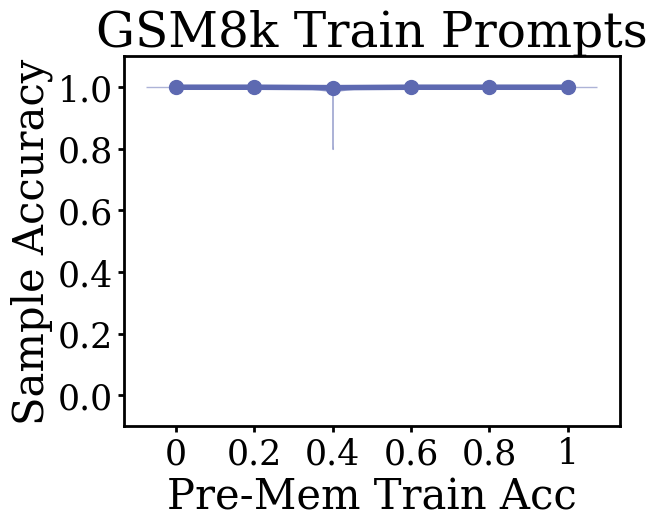

In [138]:
# plt.violinplot(acc_bins, positions=[0, 0.2, 0.4, 0.6, 0.8, 1], widths=0.15, showextrema=False, showmeans=False)
# plt.plot(np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), [np.mean(x) for x in acc_bins], "o-", color="C0",)

# plt.ylim(-0.1, 1.1)


plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
})

color = Vivid_5.mpl_colors[1]#"tab:blue"

violin_parts = plt.violinplot(acc_bins, positions=[0, 0.2, 0.4, 0.6, 0.8, 1], widths=0.15, showextrema=False, showmeans=False)
plt.plot(np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), [np.mean(x) for x in acc_bins], "o-", markersize=10, linewidth=4, color=color)



# Make the violin body blue with a red border:
for vp in violin_parts['bodies']:
    vp.set_facecolor(color)
    vp.set_edgecolor(color)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
    
    
    
plt.ylim(-0.1, 1.1)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ["0", "0.2", "0.4", "0.6", "0.8", "1"], fontsize=25)
plt.yticks(fontsize=25)

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)

plt.xlabel("Pre-Mem Train Acc", fontsize=30)
plt.ylabel("Sample Accuracy", fontsize=30)

plt.title("GSM8k Train Prompts", fontsize=35)

Text(0.5, 1.0, 'GSM8k Train Prompts\n+ "We know that"')

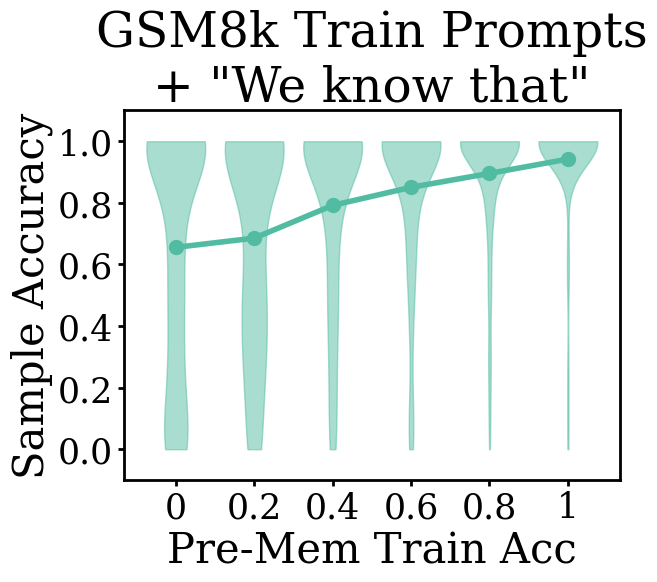

In [139]:

color = Vivid_5.mpl_colors[2]#"salmon"

violin_parts = plt.violinplot(we_acc_bins, positions=[0, 0.2, 0.4, 0.6, 0.8, 1], widths=0.15, showextrema=False, showmeans=False)
plt.plot(np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), [np.mean(x) for x in we_acc_bins], "o-", markersize=10, linewidth=4, color=color)



# Make the violin body blue with a red border:
for vp in violin_parts['bodies']:
    vp.set_facecolor(color)
    vp.set_edgecolor(color)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
    
    
    
plt.ylim(-0.1, 1.1)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ["0", "0.2", "0.4", "0.6", "0.8", "1"], fontsize=25)
plt.yticks(fontsize=25)

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)

plt.xlabel("Pre-Mem Train Acc", fontsize=30)
plt.ylabel("Sample Accuracy", fontsize=30)

plt.title("GSM8k Train Prompts\n+ \"We know that\"", fontsize=35)

Text(0.5, 1.0, 'GSM8k Train Prompts\n+"First"')

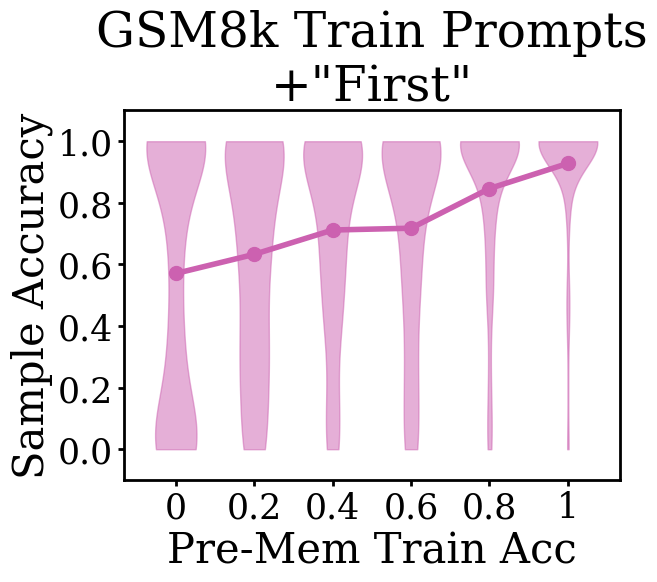

In [141]:

color = Vivid_5.mpl_colors[4]#"olive"

violin_parts = plt.violinplot(first_acc_bins, positions=[0, 0.2, 0.4, 0.6, 0.8, 1], widths=0.15, showextrema=False, showmeans=False)
plt.plot(np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), [np.mean(x) for x in first_acc_bins], "o-", markersize=10, linewidth=4, color=color)



# Make the violin body blue with a red border:
for vp in violin_parts['bodies']:
    vp.set_facecolor(color)
    vp.set_edgecolor(color)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
    
    
    
plt.ylim(-0.1, 1.1)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ["0", "0.2", "0.4", "0.6", "0.8", "1"], fontsize=25)
plt.yticks(fontsize=25)

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)

plt.xlabel("Pre-Mem Train Acc", fontsize=30)
plt.ylabel("Sample Accuracy", fontsize=30)

plt.title("GSM8k Train Prompts\n+\"First\"", fontsize=35)

In [142]:
stats_dict = get_stats("math_orig_6epochs_full2_lr2e-05_bs24")
perp_threshold=-1.7

ratios_dict =  get_ratios2(stats_dict, perp_threshold=perp_threshold)

In [143]:
we_acc = (np.load("ckpts/math_orig_6epochs_full2_lr2e-05_bs24/checkpoint-1872/train_we_answer_types10_seed2.npy")==0).mean(axis=-1)
first_acc = (np.load("ckpts/math_orig_6epochs_full2_lr2e-05_bs24/checkpoint-1872/train_first_answer_types10_seed2.npy")==0).mean(axis=-1)
acc = (np.load("ckpts/math_orig_6epochs_full2_lr2e-05_bs24/checkpoint-1872/train_answer_types10_seed2.npy")==0).mean(axis=-1)[:1000]

(array([5578.,  898.,  488.,  156.,  122.,   95.,   43.,   36.,   29.,
          28.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

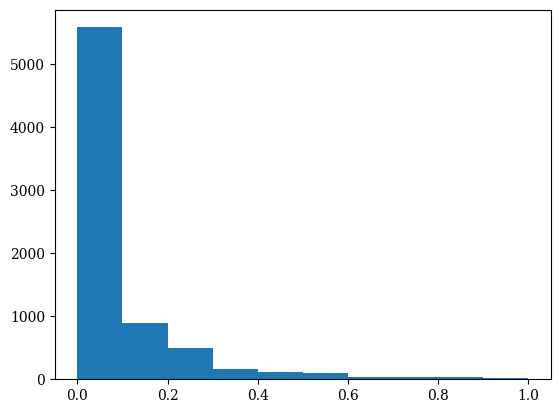

In [144]:
plt.hist(ratios_dict["unmemorized_acc_cummax_all"][-1])

In [145]:
ratios_dict["unmemorized_acc_cummax_all"][-1]

array([0.06, 0.08, 0.86, ..., 0.  , 0.  , 0.  ])

In [161]:

we_acc_bins = []
acc_bins = []
first_acc_bins = []
unmem_acc_avgs = []
for frac in [0, 0.2, 0.4, 0.6, 0.8]:
    subsample_idxs =  np.where((ratios_dict["unmemorized_acc_cummax_all"][-1][:1000]>=frac)*(ratios_dict["unmemorized_acc_cummax_all"][-1][:1000]<frac+0.2))[0]
    unmem_acc_avgs.append(ratios_dict["unmemorized_acc_cummax_all"][-1][subsample_idxs].mean())
    we_acc_bins.append(we_acc[subsample_idxs])
    acc_bins.append(acc[subsample_idxs])
    first_acc_bins.append(first_acc[subsample_idxs])


Text(0.5, 1.0, 'MATH Train Prompts')

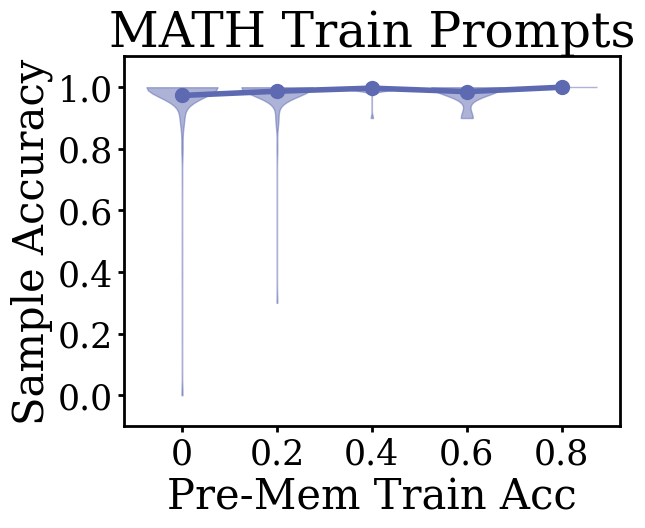

In [162]:
# plt.violinplot(acc_bins, positions=[0, 0.2, 0.4, 0.6, 0.8, 1], widths=0.15, showextrema=False, showmeans=False)
# plt.plot(np.array([0, 0.2, 0.4, 0.6, 0.8, 1]), [np.mean(x) for x in acc_bins], "o-", color="C0",)

# plt.ylim(-0.1, 1.1)


plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
})

color = Vivid_5.mpl_colors[1]#"tab:blue"

violin_parts = plt.violinplot(acc_bins, positions=[0, 0.2, 0.4, 0.6, 0.8], widths=0.15, showextrema=False, showmeans=False)
plt.plot(np.array([0, 0.2, 0.4, 0.6, 0.8]), [np.mean(x) for x in acc_bins], "o-", markersize=10, linewidth=4, color=color)



# Make the violin body blue with a red border:
for vp in violin_parts['bodies']:
    vp.set_facecolor(color)
    vp.set_edgecolor(color)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
    
    
    
plt.ylim(-0.1, 1.1)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8], ["0", "0.2", "0.4", "0.6", "0.8"], fontsize=25)
plt.yticks(fontsize=25)

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)

plt.xlabel("Pre-Mem Train Acc", fontsize=30)
plt.ylabel("Sample Accuracy", fontsize=30)

plt.title("MATH Train Prompts", fontsize=35)

Text(0.5, 1.0, 'MATH Train Prompts\n+ "We know that"')

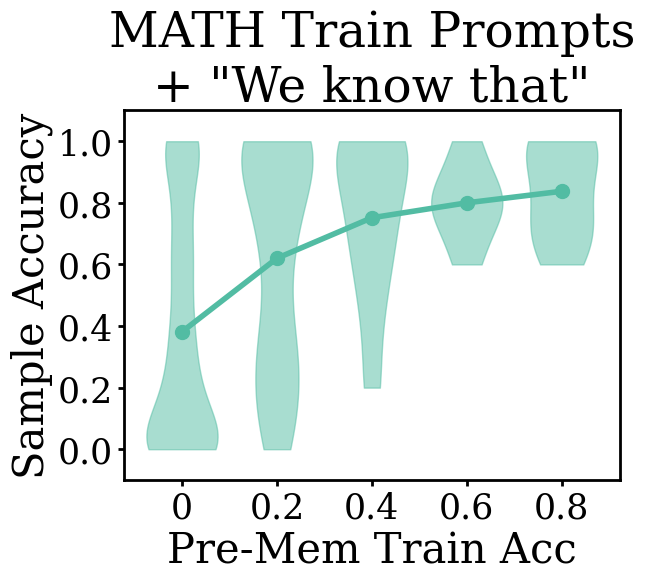

In [163]:

color = Vivid_5.mpl_colors[2]

violin_parts = plt.violinplot(we_acc_bins, positions=[0, 0.2, 0.4, 0.6, 0.8], widths=0.15, showextrema=False, showmeans=False)
plt.plot(np.array([0, 0.2, 0.4, 0.6, 0.8]), [np.mean(x) for x in we_acc_bins], "o-", markersize=10, linewidth=4, color=color)



# Make the violin body blue with a red border:
for vp in violin_parts['bodies']:
    vp.set_facecolor(color)
    vp.set_edgecolor(color)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
    
    
    
plt.ylim(-0.1, 1.1)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8], ["0", "0.2", "0.4", "0.6", "0.8"], fontsize=25)
plt.yticks(fontsize=25)

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)

plt.xlabel("Pre-Mem Train Acc", fontsize=30)
plt.ylabel("Sample Accuracy", fontsize=30)

plt.title("MATH Train Prompts\n+ \"We know that\"", fontsize=35)

Text(0.5, 1.0, 'MATH Train Prompts\n+"First"')

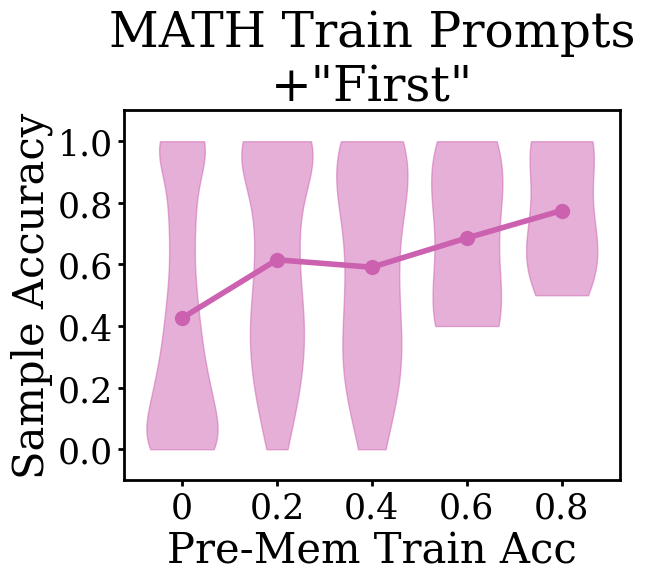

In [164]:

color = Vivid_5.mpl_colors[4]

violin_parts = plt.violinplot(first_acc_bins, positions=[0, 0.2, 0.4, 0.6, 0.8], widths=0.15, showextrema=False, showmeans=False)
plt.plot(np.array([0, 0.2, 0.4, 0.6, 0.8]), [np.mean(x) for x in first_acc_bins], "o-", markersize=10, linewidth=4, color=color)



# Make the violin body blue with a red border:
for vp in violin_parts['bodies']:
    vp.set_facecolor(color)
    vp.set_edgecolor(color)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
    
    
    
plt.ylim(-0.1, 1.1)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8], ["0", "0.2", "0.4", "0.6", "0.8"], fontsize=25)
plt.yticks(fontsize=25)

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.tick_params(width=2, length=4)

plt.xlabel("Pre-Mem Train Acc", fontsize=30)
plt.ylabel("Sample Accuracy", fontsize=30)

plt.title("MATH Train Prompts\n+\"First\"", fontsize=35)

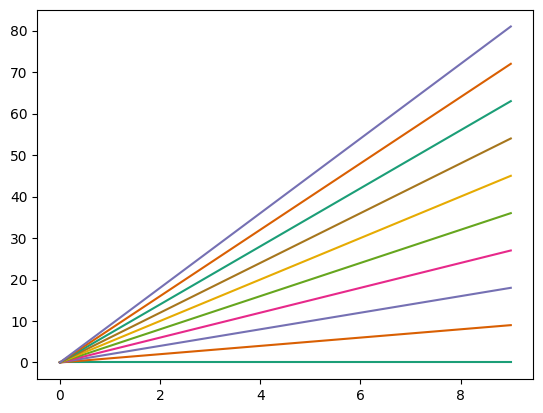

In [113]:
from palettable.colorbrewer.qualitative import Dark2_7
plt.gca().set_prop_cycle('color', Dark2_7.mpl_colors)
for i in range(10):
    plt.plot(np.arange(10) * i)

In [115]:
Dark2_7.mpl_colors

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

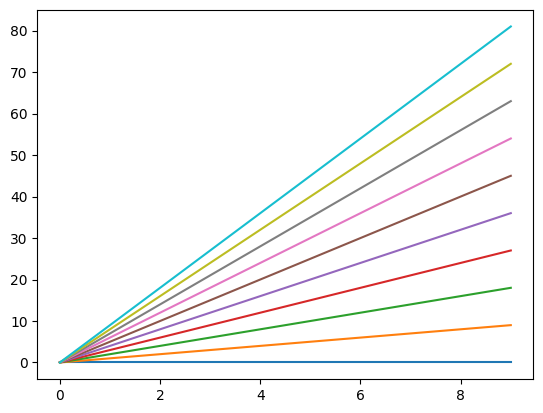

In [114]:
for i in range(10):
    plt.plot(np.arange(10) * i)